In [1]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
#library(repr)
#library(infer)
#library(cowplot)
#options(repr.matrix.max.rows = 6)
#source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")
tail(players)
tail(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,28/08/2024 23:31,29/08/2024 00:15,1.72489e+12,1.72489e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,10/05/2024 23:01,10/05/2024 23:07,1.71538e+12,1.71538e+12
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,01/07/2024 04:08,01/07/2024 04:19,1.71981e+12,1.71981e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


Clean data and make session data useable, combine data

In [3]:
clean_sessions <- sessions |>
    mutate(start_dt = dmy_hm(start_time),
           end_dt = dmy_hm(end_time),
           session_time_in_hrs = as.numeric(end_dt - start_dt) / 60) |>
    group_by(hashedEmail) |>
    summarise(total_session_time_hrs = round(sum(session_time_in_hrs), 2), 
              average_session_time_hrs = round(mean(session_time_in_hrs), 2),
              num_of_sessions = n()) |>
    filter(!is.na(total_session_time_hrs) | !is.na(average_session_time_hrs)) |>
    ungroup() |>
    select(hashedEmail, total_session_time_hrs, average_session_time_hrs, num_of_sessions)

clean_players <- merge(players, clean_sessions, by = "hashedEmail") |>
    select(experience, subscribe, Age, total_session_time_hrs, average_session_time_hrs, num_of_sessions)

clean_players

experience,subscribe,Age,total_session_time_hrs,average_session_time_hrs,num_of_sessions
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<int>
Regular,TRUE,20,1.77,0.88,2
Pro,FALSE,21,0.50,0.50,1
Beginner,TRUE,17,0.18,0.18,1
Regular,TRUE,17,6.97,0.54,13
Pro,TRUE,17,1.17,0.58,2
Veteran,FALSE,19,0.17,0.17,1
Amateur,TRUE,21,0.83,0.83,1
Amateur,TRUE,14,20.28,0.49,41
Beginner,FALSE,37,0.30,0.30,1


Plot stuff

Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_bar()`).”


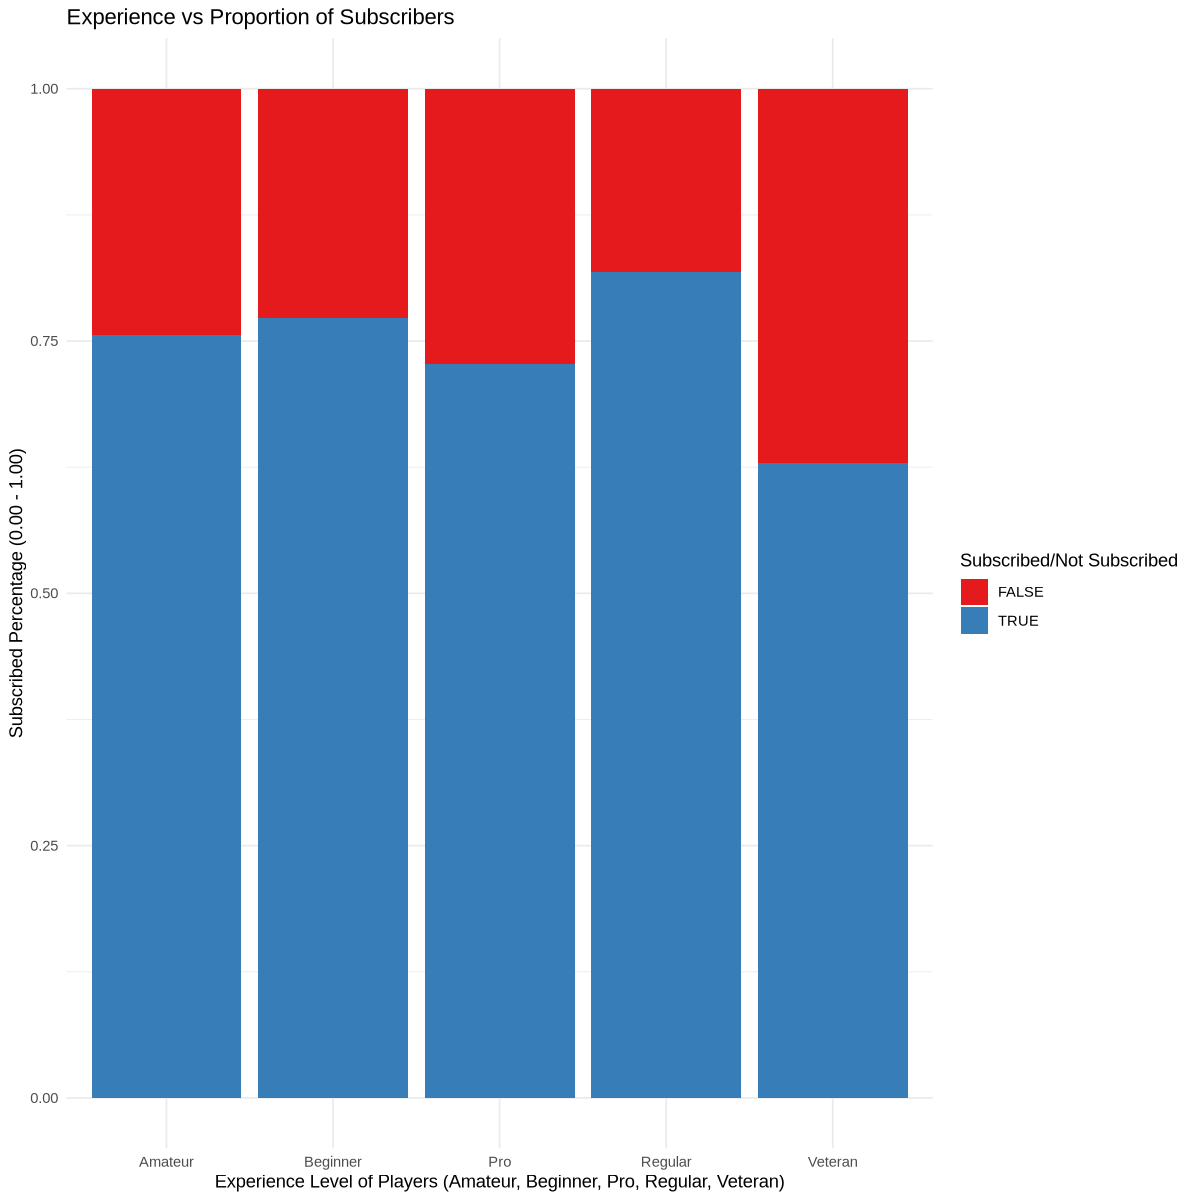

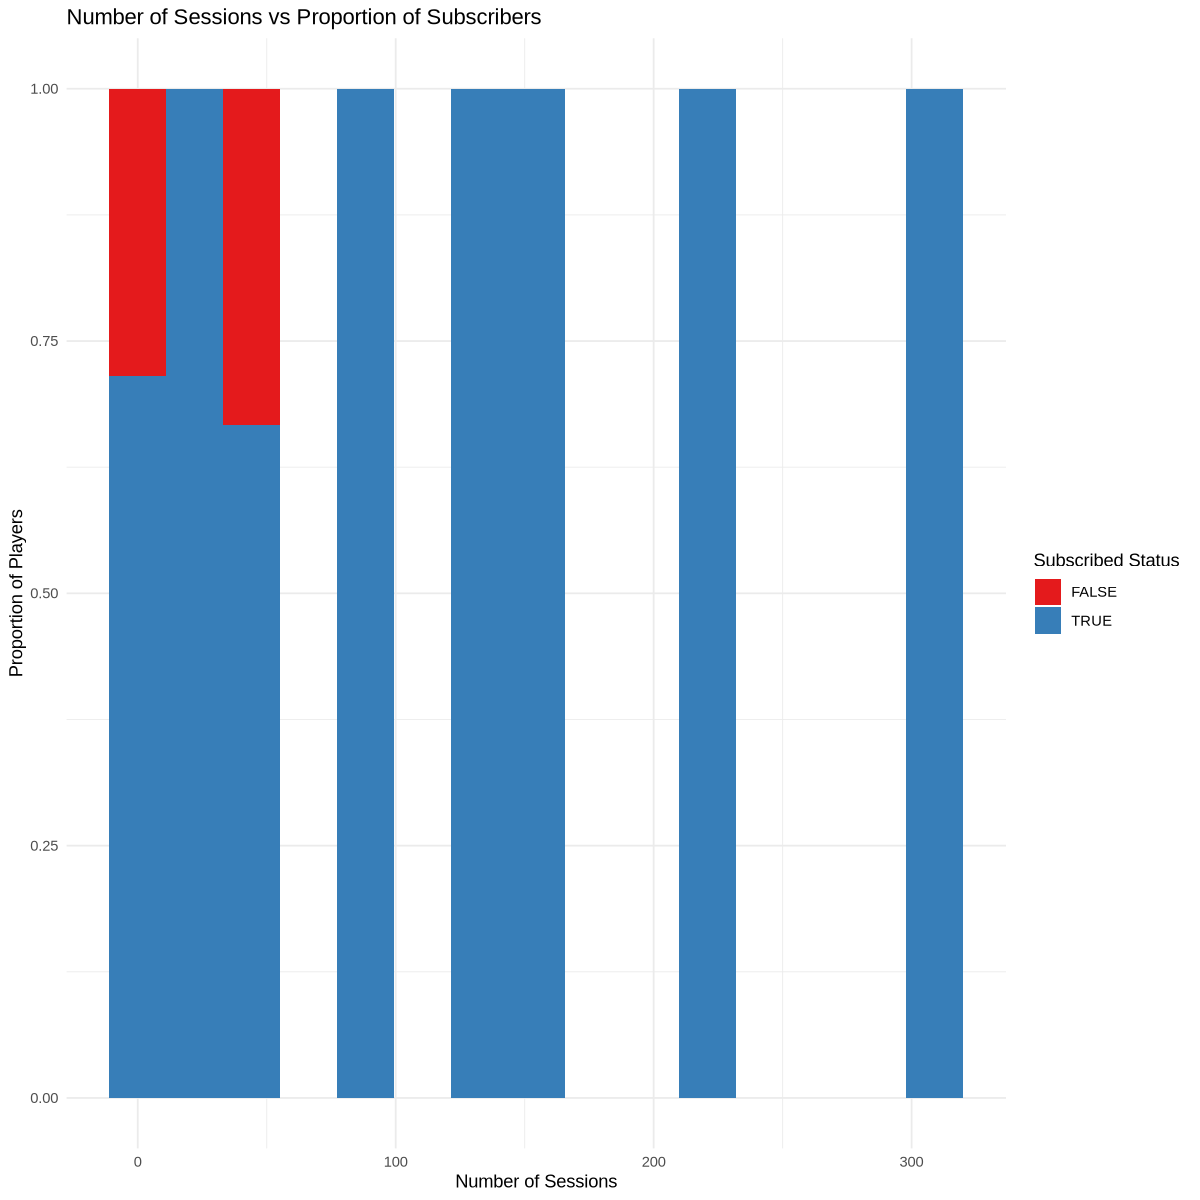

In [4]:
options(repr.plot.width = 10, repr.plot.height = 10)

experience_vs_sub <- clean_players |>
    ggplot(aes(x = experience, fill = subscribe)) + geom_bar(position = "fill") +
    labs(x = "Experience Level of Players (Amateur, Beginner, Pro, Regular, Veteran)",
         y = "Subscribed Percentage (0.00 - 1.00)",
         fill = "Subscribed/Not Subscribed") +
    ggtitle("Experience vs Proportion of Subscribers") + 
    scale_fill_brewer(palette = "Set1") + 
    theme_minimal()

session_freq_vs_sub <- clean_players |> 
    ggplot(aes(x = num_of_sessions, fill = subscribe)) +
    geom_histogram(position = "fill", bins = 15) +
    labs(x = "Number of Sessions",
         y = "Proportion of Players",
         fill = "Subscribed Status") +
    ggtitle("Number of Sessions vs Proportion of Subscribers") +
    scale_fill_brewer(palette = "Set1") + 
    theme_minimal()

experience_vs_sub
session_freq_vs_sub

split

In [10]:
clean_players = clean_players |>
    mutate(subscribe = as.factor(clean_players$subscribe),
           experience = as.factor(clean_players$experience))

[1] 10

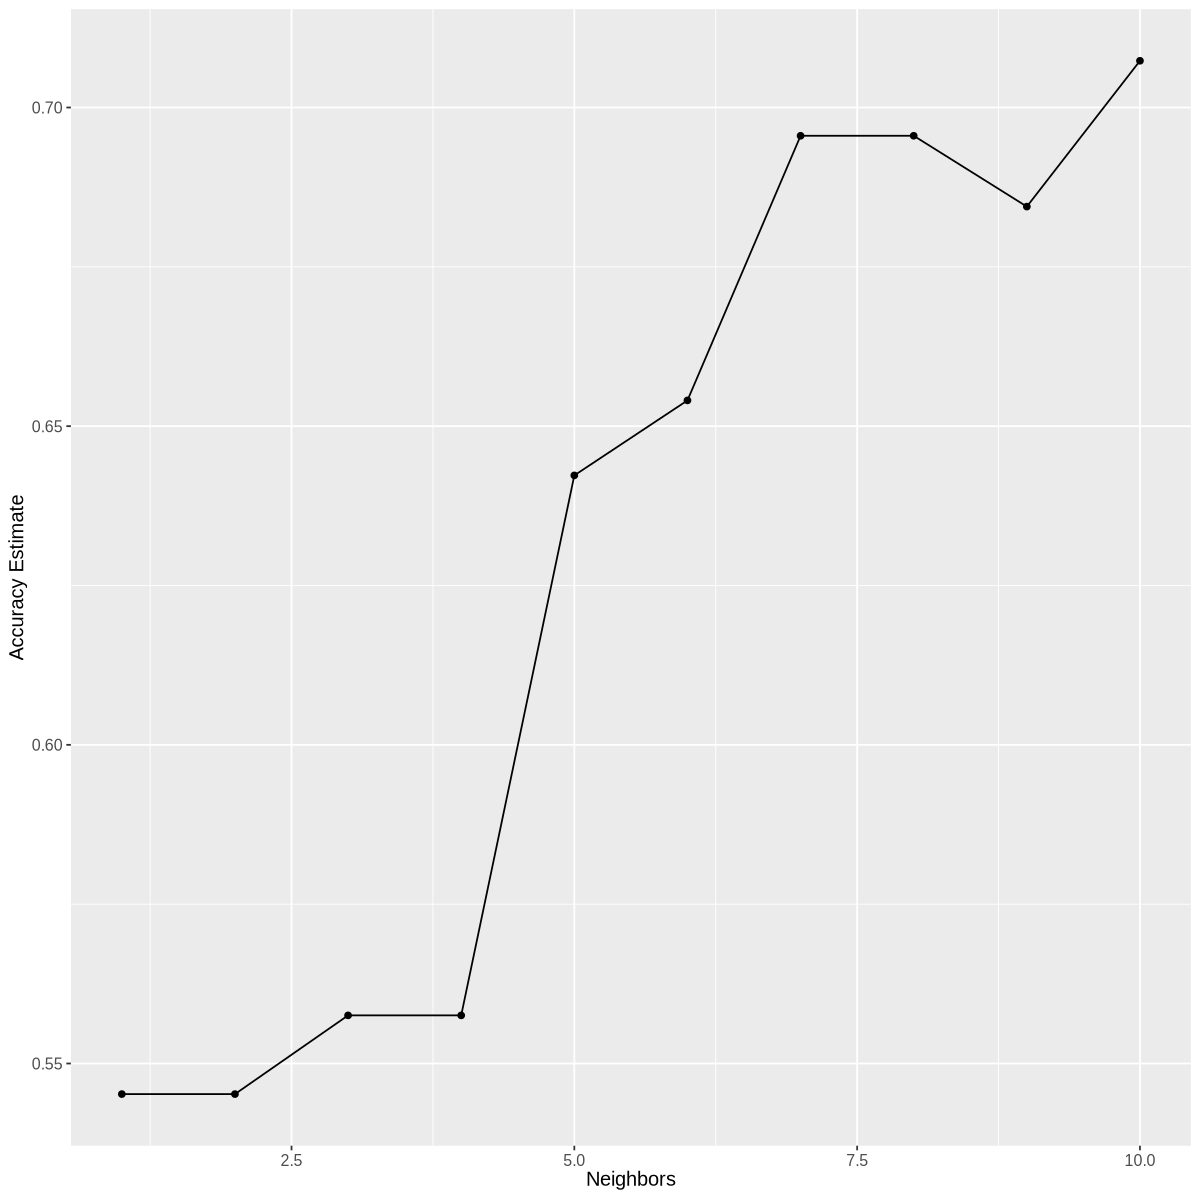

In [15]:
set.seed(123) # Ensures same best k value each time

players_split <- initial_split(clean_players, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_recipe <- recipe(subscribe ~ experience + average_session_time_hrs + num_of_sessions,
                         data = players_training) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors())

test_knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

training_vfold = vfold_cv(players_training, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(test_knn_spec) |>
    tune_grid(resamples = training_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k <- accuracies  |>
    ggplot(aes(x = neighbors, y = mean)) + geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

accuracy_vs_k
# Visually we can see that k = 10 is the best, 
# but we can also double check using the following:

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k
accuracy_vs_k



Run using new k value

In [18]:
players_tuned_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("classification")

players_best_fit = workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_tuned_spec) |>
    fit(data = players_training)